# <font color = 'orange'> Model Trainer

---

In [1]:
import os

In [2]:
%pwd

'e:\\PW Skills - Data Science\\Projects\\09_Chest_Cancer_Classification\\notebook'

In [3]:
os.chdir('../')

In [4]:
%pwd

'e:\\PW Skills - Data Science\\Projects\\09_Chest_Cancer_Classification'

---

In [5]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    validation_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list

In [6]:
from chest_cancer_classifier.utils.common import read_yaml, create_directories
from chest_cancer_classifier.constants import *


class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH
    ):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])


    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        
        create_directories([Path(training.root_dir)])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path=Path(prepare_base_model.updated_base_model_path),
            training_data=Path(training.training_data),
            validation_data=Path(training.validation_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE
        )

        return training_config

In [13]:
import tensorflow as tf
import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input


class ModelTraining:
    def __init__(self, config: TrainingConfig):
        self.config = config

    
    def get_base_model(self):
        self.model = keras.models.load_model(
            self.config.updated_base_model_path
        )


    def train_valid_generator(self):
        IMAGE_SIZE = self.config.params_image_size[:-1]
        if self.config.params_is_augmentation:
            data_generator_kwargs = dict(                
                preprocessing_function = preprocess_input,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
            generator_kwargs = dict(
                target_size=IMAGE_SIZE,
                batch_size=self.config.params_batch_size,
                class_mode='binary'
            )
            
            train_datagen = ImageDataGenerator(**data_generator_kwargs)
            self.train_generator = train_datagen.flow_from_directory(
                self.config.training_data,
                **generator_kwargs
            )
                    
            test_datagen = ImageDataGenerator(**data_generator_kwargs)
            self.valid_generator = test_datagen.flow_from_directory(
                self.config.validation_data,
                **generator_kwargs
            )
        else:
            generate_kwargs = dict(
                labels='inferred',
                label_mode = 'int',
                batch_size=self.config.params_batch_size,
                image_size=IMAGE_SIZE
            )
            
            self.train_generator = keras.utils.image_dataset_from_directory(
                directory = self.config.training_data,
                **generate_kwargs
            )
            self.train_generator = self.train_generator.map(preprocess_input)

            self.valid_generator = keras.utils.image_dataset_from_directory(
                directory = self.config.validation_data,
                **generate_kwargs
            )
            self.valid_generator = self.valid_generator.map(preprocess_input)

    
    def save_figures(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(30, 15))
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(self.histories.history['accuracy'],color='red',label='train')
        ax1.plot(self.histories.history['val_accuracy'],color='blue',label='validation')
        ax1.legend()
        ax1.set_title('Accuracy')
        ax2.plot(self.histories.history['loss'],color='red',label='train')
        ax2.plot(self.histories.history['val_loss'],color='blue',label='validation')
        ax2.legend()        
        ax2.set_title('Loss')
        plt.suptitle('Metrics') 
        plt.show()
        
        import mlflow
        with mlflow.start_run():
                mlflow.log_figure(fig, "metrics.png")
    
    
    @staticmethod
    def save_model(path: Path, model: keras.Model):
        model.save(path)

    
    def train(self):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        self.histories = self.model.fit(
            self.train_generator,
            epochs=self.config.params_epochs,
            steps_per_epoch=self.steps_per_epoch,
            validation_data=self.valid_generator,
            validation_steps=self.validation_steps
        )
        
        self.save_figures()

        self.save_model(
            path=self.config.trained_model_path,
            model=self.model
        )

[2024-04-23 16:46:19,465: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-04-23 16:46:19,477: INFO: common: yaml file: params.yaml loaded successfully]
[2024-04-23 16:46:19,481: INFO: common: created directory at: artifacts]
[2024-04-23 16:46:19,483: INFO: common: created directory at: artifacts\training]
Found 343 images belonging to 2 classes.
Found 343 images belonging to 2 classes.
Epoch 1/2


C:\Users\darsh\AppData\Local\Temp\ipykernel_264\4116033494.py:98: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.histories = self.model.fit_generator(


24/24 [==============================] - 109s 5s/step - loss: 7.6660 - accuracy: 0.8389 - val_loss: 2.3567 - val_accuracy: 0.8869
Epoch 2/2
24/24 [==============================] - 110s 5s/step - loss: 1.0961 - accuracy: 0.9544 - val_loss: 0.7112 - val_accuracy: 0.9554


<Figure size 3000x1500 with 0 Axes>

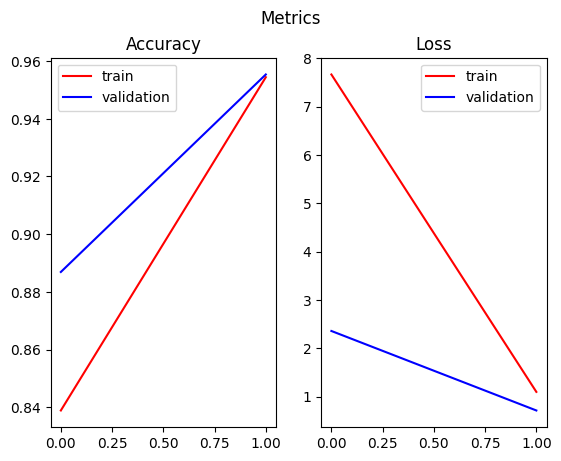

In [14]:
try:
    config = ConfigurationManager()
    training_config = config.get_training_config()
    training = ModelTraining(config=training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train()

except Exception as e:
    raise e

---